In [2]:
import pickle
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import DistanceMetric
from sklearn.metrics import r2_score, mean_squared_error
import theano.tensor as tt
from theano import shared
import pandas as pd
from pandas.plotting import scatter_matrix
from tqdm import tqdm
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rcParams
from seaborn import PairGrid, heatmap, kdeplot
import cmocean.cm as cmo

In [3]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16

In [4]:
tqdm.monitor_interval = 0

In [17]:
class PyMCModel:
    def __init__(self, model, X, y, model_name='None'):
        self.model = model(X, y)
        self.model.name = model_name
        
    def fit(self, n_samples=2000):
        with self.model:
            self.trace_ = pm.sample(n_samples)
    
    def fit_ADVI(self, n_samples=2000, n_iter=100000, inference='advi'):
        with self.model:
            approx_fit = pm.fit(n=n_iter, method=inference)
            self.trace_ = approx_fit.sample(draws=n_samples)
    
    def show_model(self):
        return pm.model_to_graphviz(self.model)
    
    def predict(self, X):
        return X.dot(self.trace_['w'].T) + self.trace_['alpha']
    
    def evaluate_fit(self, show_feats):
        return pm.traceplot(self.trace_, varnames=show_feats)
    
    def show_forest(self, show_feats, feat_labels=None):
        g = pm.forestplot(self.trace_, varnames=show_feats,
                             ylabels=feat_labels)
        f = pl.gcf()
        ax = f.get_axes()[1]
        ax.grid(axis='y')
        return g
    
    def plot_model_fits(self, y_obs, title=None, ax=None):
        y_model = self.trace_.get_values('mu')
        y_model_mean = np.mean(y_model, axis=0)

        y_model_hpd = pm.hpd(y_model)

        ppc_y = pm.sample_ppc(self.trace_, model=self.model)['y']
        ppc_y_mean = ppc_y.mean(axis=0)
        hpd = pm.hpd(ppc_y)
        try:
            rmse = np.sqrt(mean_squared_error(y_obs, y_model_mean))
        except ValueError:
            mask = np.isnan(y_obs)
            y_model_mean = np.ma.array(data=y_model_mean, mask=mask).compressed()
            y_obs = np.ma.array(data=y_obs, mask=mask).compressed()
        finally:    
            r2 = r2_score(y_obs, y_model_mean)
            rmse = np.sqrt(mean_squared_error(y_obs, y_model_mean))
        if ax is None:
            _, ax = pl.subplots(figsize=(10, 10),)# nrows=2)
        ax.set_title('Model Fit')
        ax.set_xlabel('modeled')
        ax.set_ylabel('observed')
        ax.scatter(y_model_mean, y_obs, color='k', alpha=0.5,
                     label='$log_{10}(chl)$, $r^2=%.2f$, rmse=%.2f' %(r2, rmse));
        ax.plot([-1.5, 1.5], [-1.5, 1.5], 'k--', label='1:1')
        ax.axis('equal')
        ax.legend(loc='best')
        """ix = np.argsort(y_obs.ravel())
        xi = np.arange(y_obs.size)
        ax[1].set_title('Posterior Predictive Checks')
        ax[1].set_xlabel('obs #')
        ax[1].set_ylabel('$log_{10}(chl)$')
        ax[1].plot(y_obs.ravel()[ix], ls='', marker='.', color='k', label='Obs')
        ax[1].plot(ppy_y_mean[ix], ls='', color='r', marker='o', markersize=10,
                   alpha=0.7, label='PPC mean')
        ax[1].fill_between(xi, hpd[ix, 0], hpd[ix, 1], color='orange',
                           alpha=0.3, label='PPC 95% Cred. Int.');
        ax[1].legend(loc='best');"""
        f = pl.gcf()
        f.suptitle(title, y=1.01);
        f.tight_layout()
        return ax

In [10]:
def hs_regression(X, y_obs, ylabel='y', tau_0=None, regularized=False, **kwargs):
    """See Piironen & Vehtari, 2017 (DOI: 10.1214/17-EJS1337SI)"""
    if tau_0 is None:
        M = X.shape[1]
        m0 = M/2
        N = X.shape[0]
        tau_0 = m0 / ((M - m0) * np.sqrt(N))
    if regularized:
        slab_scale = kwargs.pop('slab_scale', 3)
        slab_scale_sq = slab_scale ** 2
        slab_df = kwargs.pop('slab_df', 8)
        half_slab_df = slab_df / 2
        with pm.Model() as mhsr:
            tau = pm.HalfCauchy('tau', tau_0)
            c_sq = pm.InverseGamma('c_sq', alpha=half_slab_df,
                                   beta=half_slab_df * slab_scale_sq)
            lamb_m = pm.HalfCauchy('lambda_m', beta=1)
            lamb_m_bar = tt.sqrt(c_sq) * lamb_m / (tt.sqrt(c_sq + 
                                                           tt.pow(tau, 2) *
                                                           tt.pow(lamb_m, 2)
                                                          )
                                                  )
            w = pm.Normal('w', mu=0, sd=tau*lamb_m_bar, shape=X.shape[1])
            mu_ = pm.Deterministic('mu', tt.dot(X, w))
            sig = pm.HalfCauchy('sigma', beta=10)
            y = pm.Normal('y', mu=mu_, sd=sig, observed=y_obs.squeeze())
        return mhsr
    else:
        with pm.Model() as mhs:
            tau = pm.HalfCauchy('tau', tau_0)
            lamb_m = pm.HalfCauchy('lambda_m', beta=1)
            w = pm.Normal('w', mu=0, sd = tau*lamb_m, shape=X.shape[1])
            mu_ = pm.Deterministic('mu', tt.dot(X, w))
            sig = pm.HalfCauchy('sigma', beta=10)
            y = pm.Normal('y', mu=mu_, sd=sig, observed=y_obs.squeeze())
        return mhs

    
def lasso_regression(X, y_obs, ylabel='y'):
    num_obs, num_feats = X.shape
    with pm.Model() as mlasso:
        sd_beta = pm.HalfCauchy('sd_beta', beta=2.5)
        sig = pm.HalfCauchy('sigma', beta=2.5)
        alpha = pm.Laplace('alpha', mu=0, b=sd_beta)
        w = pm.Laplace('w', mu=0, b=sd_beta, shape=num_feats)
        mu_ = pm.Deterministic('mu', alpha + tt.dot(X, w))
        y = pm.Normal('y', mu=mu_, sd=sig, observed=y_obs.squeeze())
    return mlasso


def hier_lasso_regr(X, y_obs, add_bias=True, ylabel='y'):
    num_obs, num_feats = X.shape
    with pm.Model() as mlasso:
        hyp_beta = pm.HalfCauchy('hyp_beta', beta=2.5)
        hyp_mu = pm.HalfCauchy('hyp_mu', mu=0, beta=2.5)
        sig = pm.HalfCauchy('sigma', beta=2.5)
        alpha = pm.Laplace('alpha', mu=hyp_mu, b=hyp_beta)
        w = pm.Laplace('w', mu=hyp_mu, b=hyp_beta, shape=num_feats)
        mu_ = pm.Deterministic('mu', alpha + tt.dot(X, w))
        y = pm.Normal('y', mu=mu_, sd=sig, observed=y_obs.squeeze())
    return mlasso



#def biome_hier_regression(X, y_obs, add_bias=True, ylabel='y'):
#    if add_bias:
#        X = np.c_[np.ones((X.shape[0],)), X]
#    with pm.Model() as mbhlasso:
#        sd_beta = pm.HalfCauchy('sd_beta', beta=2.5)
#        wh = 

def Plot_Model_Fits(trace, model, title=None, ax=None):
    mu_log10chl = trace.get_values('mu')
    mu_log10chl_mean = np.median(mu_log10chl, axis=0)

    mu_hpd = pm.hpd(mu_log10chl)

    ppc_y = pm.sample_ppc(trace, model=model)['y']
    mn = ppc_y.mean(axis=0)
    hpd = pm.hpd(ppc_y)
    rmse = np.sqrt(mean_squared_error(y, mu_log10chl_mean))
    r2 = r2_score(y, mu_log10chl_mean)
    if ax is None:
        _, ax = pl.subplots(figsize=(10, 18), nrows=2)
    ax[0].set_title('Model Fit')
    ax[0].set_xlabel('modeled')
    ax[0].set_ylabel('observed')
    ax[0].scatter(mu_log10chl_mean, y, color='k', alpha=0.5,
                 label='$log_{10}(chl)$, $r^2=%.2f$, rmse=%.2f' %(r2, rmse));
    ax[0].plot([-1.5, 1.5], [-1.5, 1.5], 'k--', label='1:1')
    ax[0].axis('equal')
    ax[0].legend(loc='best')
    ix = np.argsort(y.ravel())
    xi = np.arange(y.size)
    ax[1].set_title('Posterior Predictive Checks')
    ax[1].set_xlabel('obs #')
    ax[1].set_ylabel('$log_{10}(chl)$')
    ax[1].plot(y.ravel()[ix], ls='', marker='.', color='k', label='Obs')
    ax[1].plot(mn[ix], ls='', color='r', marker='o', markersize=10,
               alpha=0.7, label='PPC mean')
    ax[1].fill_between(xi, hpd[ix, 0], hpd[ix, 1], color='orange',
                       alpha=0.3, label='PPC 95% Cred. Int.');
    ax[1].legend(loc='best');
    f = pl.gcf()
    f.suptitle(title, y=1.01);
    f.tight_layout()
    return ax

In [6]:
ds = pd.read_pickle('./pickleJar/df_6_FullSet_noInteractions.pkl')
dps = pd.read_pickle('./pickleJar/df_6_FullSet_MaxInteractions.pkl')
dpcapoly_s = pd.read_pickle('./pickleJar/df_6_FullSet_PCAInteractions.pkl')

In [7]:
ds.head().T

,0,1,2,3,4
Biome,Westerlies,Polar,Polar,Polar,Trades
BiomCat,3,1,1,1,2
Province,"Mediterranean Sea, Black Sea Province",Antarctic Province,Austral Polar Province,Austral Polar Province,N. Atlantic Tropical Gyral Province (Trpg)
ProvCode,MEDI,ANTA,APLR,APLR,NATR
Coastal,0,0,0,0,0
ProvCat,42,22,25,25,33
sin_doy,-0.984474,0.790946,0.758306,0.369725,-0.997917
cos_doy,0.175531,0.611886,0.651899,0.929141,-0.0645084
sin_minofday,0.601815,-0.965926,-0.887011,-0.442289,0.134851
cos_minofday,-0.798636,-0.258819,-0.461749,-0.896873,-0.990866


In [8]:
feat_beg = 'sin_doy'
feat_end_ni = 'PC6_s'
feat_end_wi = 'PC5_s PC6_s'
X_s = ds.dropna().loc[:, feat_beg: feat_end_ni].values
X_s_na = ds.loc[:, feat_beg: feat_end_ni].values
Xp_s = dps.dropna().loc[:, feat_beg: feat_end_wi].values
Xp_s_na = dps.loc[:, feat_beg: feat_end_wi].values
Xpcap_s = dpcapoly_s.dropna().loc[:, feat_beg: feat_end_wi].values
Xpcap_s_na = dpcapoly_s.loc[:, feat_beg: feat_end_wi].values
y = ds.dropna().log10_chl
y_na = ds.log10_chl

### <u>No Interactions</u>
<br>
<u>1. Fitting with NaNs dropped (no imputations)</u>

In [18]:
m_lasso_ = PyMCModel(lasso_regression, X_s, y, model_name='lasso_no_imp')
m_lasso_.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, alpha, sigma, sd_beta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:09<00:00, 1109.15draws/s]


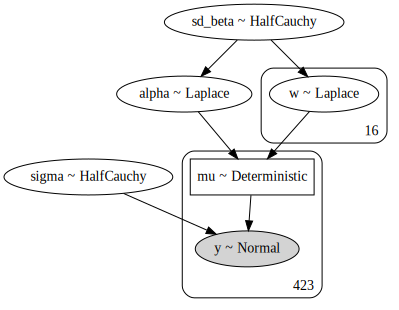

In [19]:
m_lasso_.show_model()

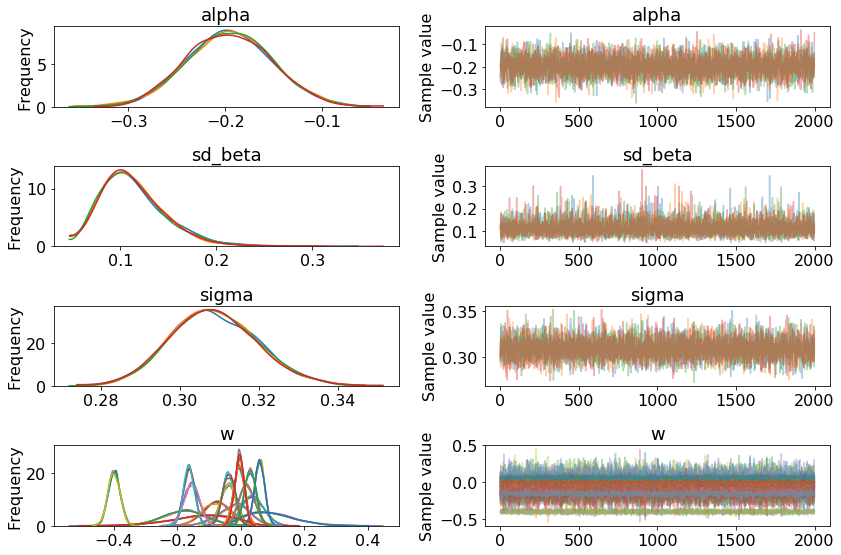

In [20]:
vars_ = ['alpha', 'sd_beta', 'sigma', 'w',]
m_lasso_.evaluate_fit(show_feats=vars_);

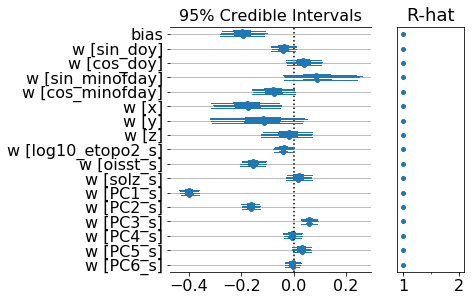

In [21]:
lbls = ds.loc[:, feat_beg: feat_end_ni].columns.tolist()
lbls_list = ['bias'] + ['w [%s]' % lbl for lbl in lbls]
m_lasso_.show_forest(['alpha', 'w'], feat_labels=lbls_list);

100%|██████████| 2000/2000 [00:01<00:00, 1630.59it/s]


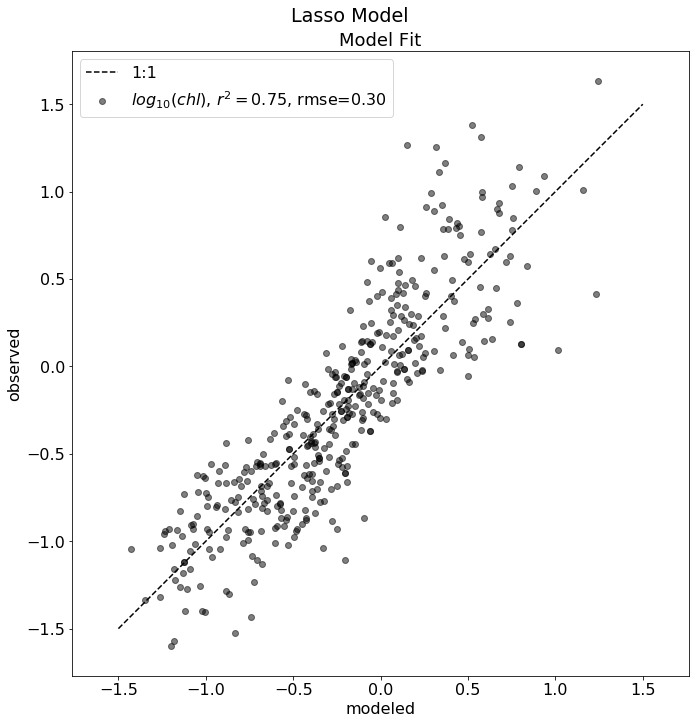

In [22]:
ax0 = m_lasso_.plot_model_fits(y_obs=y, title='Lasso Model')

<u>2. with missing data imputation</u> 

In [34]:
pred = m_lasso_na_.predict(X_s_na).T

In [35]:
pred_mean = pred.mean(axis=0)

In [36]:
hp = pm.hpd(pred)

In [37]:
hp.shape

(494, 2)

In [46]:
ix = np.argsort(pred_mean)
xi = np.arange(pred_mean.size)
y_na_ma = np.ma.array(data=y_na, mask=np.isnan(y_na)).compressed()
y_namaix = np.argsort(y_na_ma)
xi_yna = np.arange(y_namaix.size)

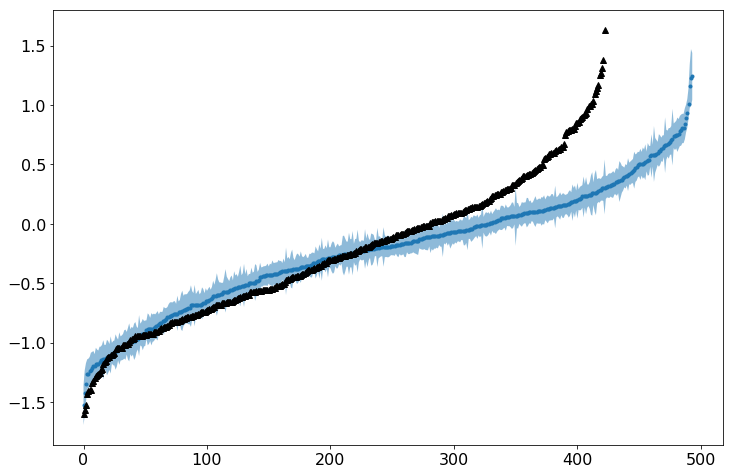

In [47]:
pl.figure(figsize=(12, 8))
pl.plot(xi, pred_mean[ix], marker='.', ls='')
pl.plot()
pl.fill_between(xi, hp[ix,0], hp[ix, 1], alpha=0.5)
pl.plot(xi_yna, y_na_ma[y_namaix], marker='^', ls='', color='k')

In [24]:
m_lasso_na_ = PyMCModel(lasso_regression, X_s_na, y_na, model_name='lasso_w_imp')
m_lasso_na_.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_missing, w, alpha, sigma, sd_beta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:13<00:00, 747.64draws/s]


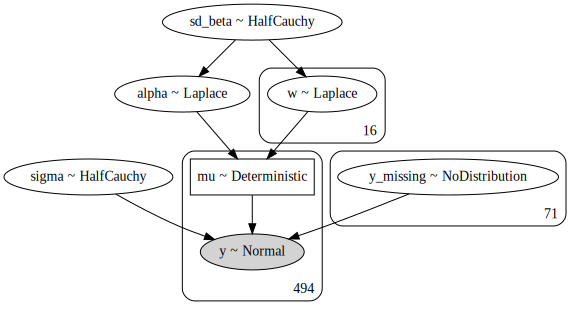

In [25]:
m_lasso_na_.show_model()

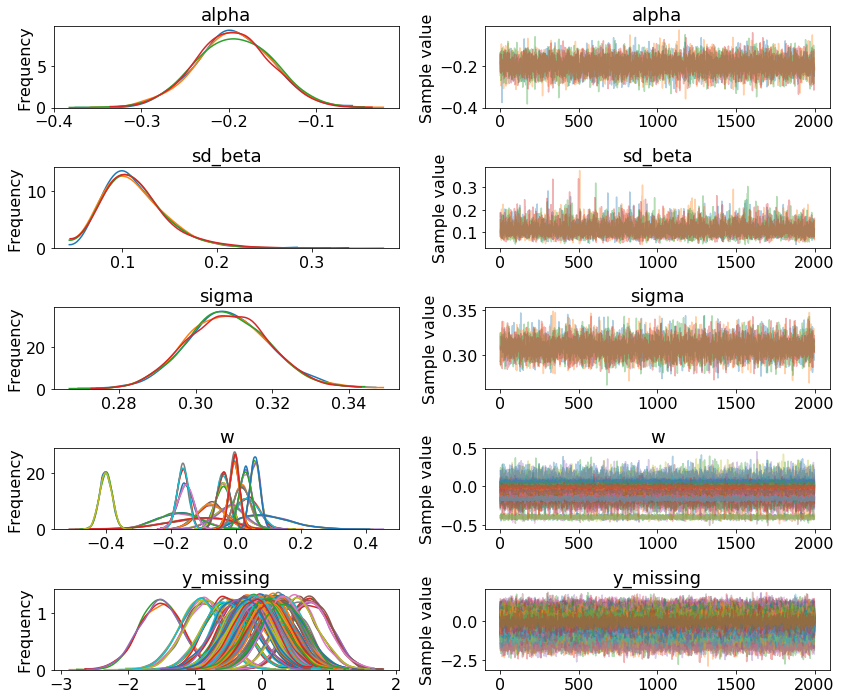

In [26]:
vars_na_ = vars_ + ['y_missing']
m_lasso_na_.evaluate_fit(vars_na_);

100%|██████████| 2000/2000 [00:01<00:00, 1556.61it/s]


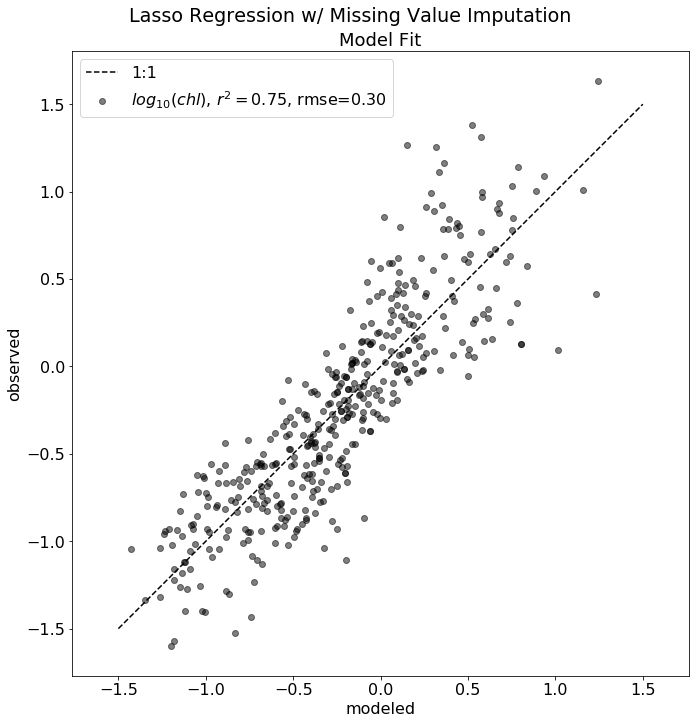

In [27]:
m_lasso_na_.plot_model_fits(y_obs=y_na,
                            title='Lasso Regression w/ Missing Value Imputation');

In [90]:
d_lasso = pm.summary(t_lasso, varnames=vars_)
lbls = ds.loc[:, 'PC1_s':].columns.tolist()[:-1]
lbls_list = ['w[bias]']+['w [%s]' % lbl for lbl in lbls]
d_lasso.index = ['sd_beta', 'sigma'] + lbls_list
d_lasso[(((d_lasso['hpd_2.5']<0)&(d_lasso['hpd_97.5']<0))|
          ((d_lasso['hpd_2.5']>0) & (d_lasso['hpd_97.5']>0)))]

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sd_beta,0.093829,0.025095,0.000279,0.052586,0.143826,9642.627054,0.999934
sigma,0.307831,0.011074,0.000092,0.285401,0.328845,10420.572364,0.999863
w[bias],-0.207991,0.015383,0.000144,-0.238302,-0.178800,10992.486422,0.999907
w [PC1_s],-0.399322,0.018617,0.000205,-0.434704,-0.362405,8683.244855,0.999812
w [PC2_s],-0.163034,0.017567,0.000190,-0.195884,-0.127735,8608.624114,1.000065
w [PC3_s],0.057677,0.015499,0.000157,0.029340,0.089563,10277.397374,1.000170
w [cos_minofday_s],-0.046374,0.021786,0.000244,-0.090047,-0.004332,9248.267868,0.999773
w [x_s],-0.067505,0.021717,0.000245,-0.112104,-0.027119,8613.608497,0.999840
w [y_s],-0.068859,0.034071,0.000410,-0.132305,-0.000540,7088.367413,0.999976
w [oisst_s],-0.158811,0.024632,0.000287,-0.208466,-0.112709,7025.265500,0.999959


In [93]:
mp_lasso = lasso_regression(Xp_s, y, ylabel='y')

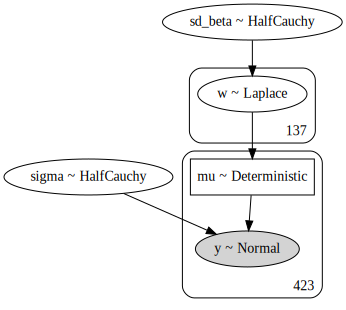

In [94]:
pm.model_to_graphviz(model=mp_lasso)

In [95]:
with mp_lasso:
    inference=pm.ADVI()
    approx_lasso_p = pm.fit(n=100000, method=inference)

Average Loss = 147.13: 100%|██████████| 100000/100000 [00:48<00:00, 2058.49it/s]
Finished [100%]: Average Loss = 147.07


In [98]:
lbls = ds.loc[:, 'PC1_s':'PC6_s'].columns.tolist()
lbls_list = ['w[bias]']+['w [%s]' % lbl for lbl in lbls]

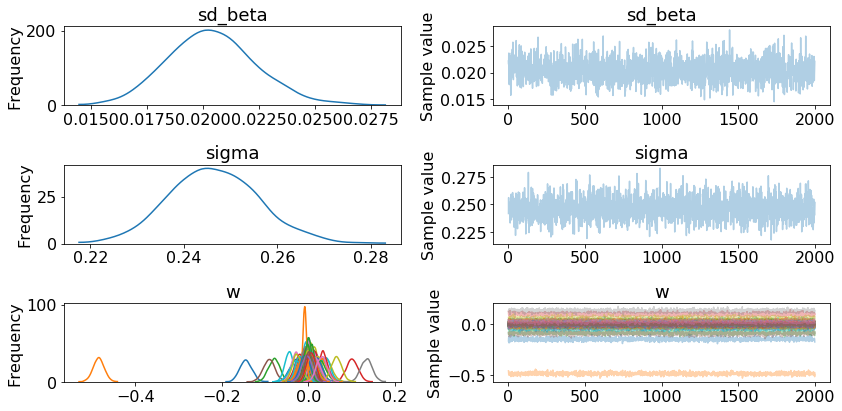

In [96]:
tp_lasso = approx_lasso_p.sample(draws=2000)
vars_ = ['sd_beta', 'sigma', 'w']
pm.traceplot(tp_lasso, varnames=vars_);

100%|██████████| 2000/2000 [00:01<00:00, 1714.74it/s]


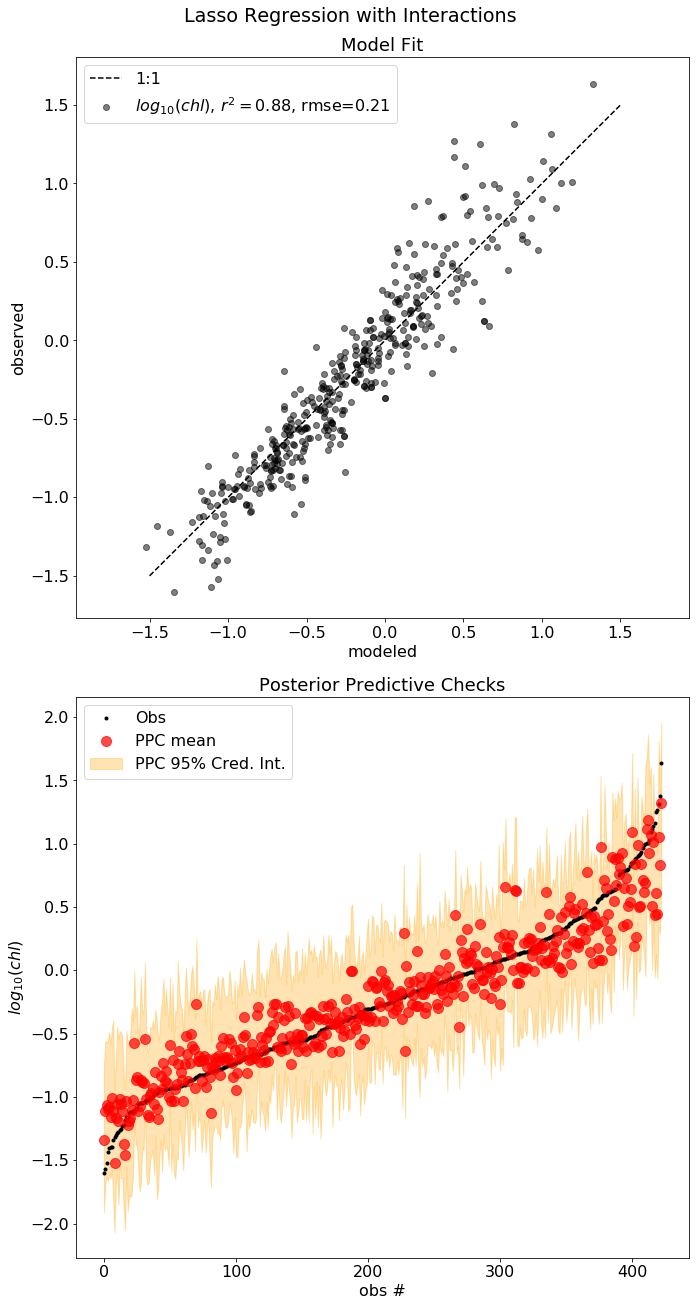

In [103]:
title = 'Lasso Regression with Interactions'
ax1lps = Plot_Model_Fits(tp_lasso, mp_lasso, title=title)

In [105]:
dp_lasso = pm.summary(tp_lasso, varnames=vars_)
lbls = dps.loc[:, 'PC1_s':].columns.tolist()[:-1]
lbls_list = ['w[bias]']+['w [%s]' % lbl for lbl in lbls]
dp_lasso.index = ['sd_beta', 'sigma'] + lbls_list
dp_lasso[(((dp_lasso['hpd_2.5']<0)&(dp_lasso['hpd_97.5']<0))|
          ((dp_lasso['hpd_2.5']>0) & (dp_lasso['hpd_97.5']>0)))]

,mean,sd,mc_error,hpd_2.5,hpd_97.5
sd_beta,0.020379,0.001982,0.000044,0.016413,0.024140
sigma,0.246332,0.009527,0.000181,0.227065,0.264786
w[bias],-0.144406,0.013855,0.000290,-0.171713,-0.118667
w [PC1_s],-0.484384,0.012628,0.000303,-0.511678,-0.461643
w [PC2_s],-0.079157,0.013028,0.000311,-0.103235,-0.051941
w [PC3_s],0.100905,0.013139,0.000287,0.075024,0.125627
w [PC4_s],0.033154,0.013258,0.000291,0.008256,0.060282
w [cos_doy_s],0.041101,0.013171,0.000308,0.013650,0.065402
w [sin_minofday_s],0.037858,0.012029,0.000292,0.015219,0.062440
w [cos_minofday_s],-0.029794,0.013713,0.000320,-0.054865,-0.001385


In [106]:
mpcap_lasso = lasso_regression(Xpcap_s, y, ylabel='y')

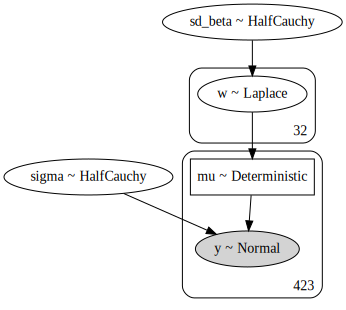

In [107]:
pm.model_to_graphviz(model=mpcap_lasso)

In [108]:
with mpcap_lasso:
    inference=pm.ADVI()
    approx_lasso_pca_p = pm.fit(n=100000, method=inference,progressbar=False)

Finished [100%]: Average Loss = 82.231


In [109]:
tpcap_lasso = approx_lasso_pca_p.sample(2000)

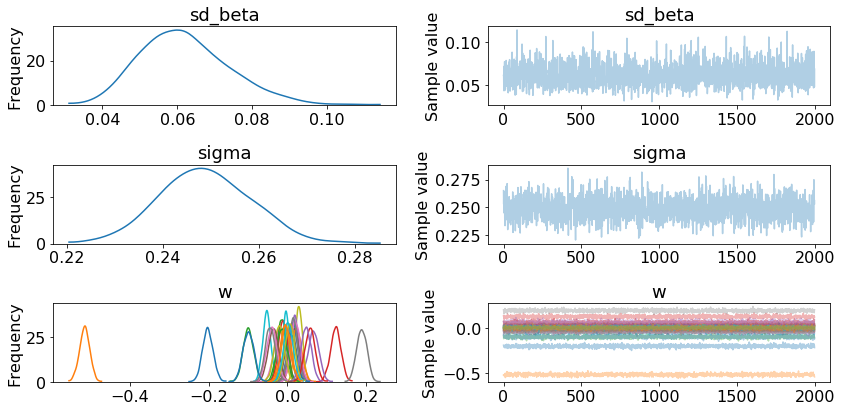

In [110]:
vars_ = ['sd_beta', 'sigma', 'w']
pm.traceplot(tpcap_lasso, varnames=vars_);

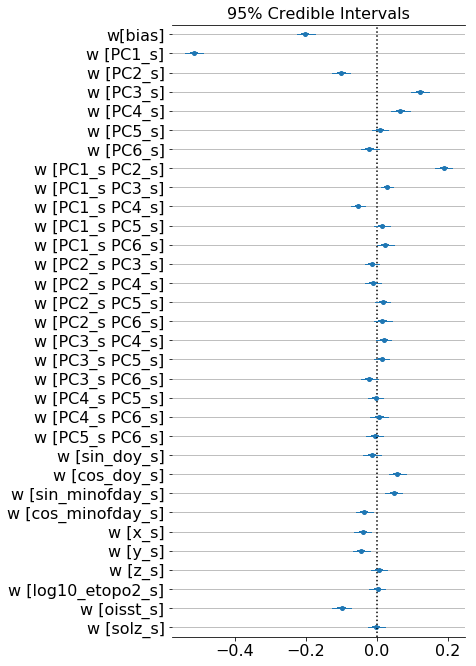

In [111]:
lbls = dpcapoly_s.loc[:, 'PC1_s':].columns.tolist()[:-1]
lbls_list = ['w[bias]']+['w [%s]' % lbl for lbl in lbls]
pm.forestplot(tpcap_lasso, varnames='w', ylabels=lbls_list);
f = pl.gcf()
f.set_figheight(10)
a = f.get_axes()[0]
a.grid(axis='y')

100%|██████████| 2000/2000 [00:01<00:00, 1777.62it/s]


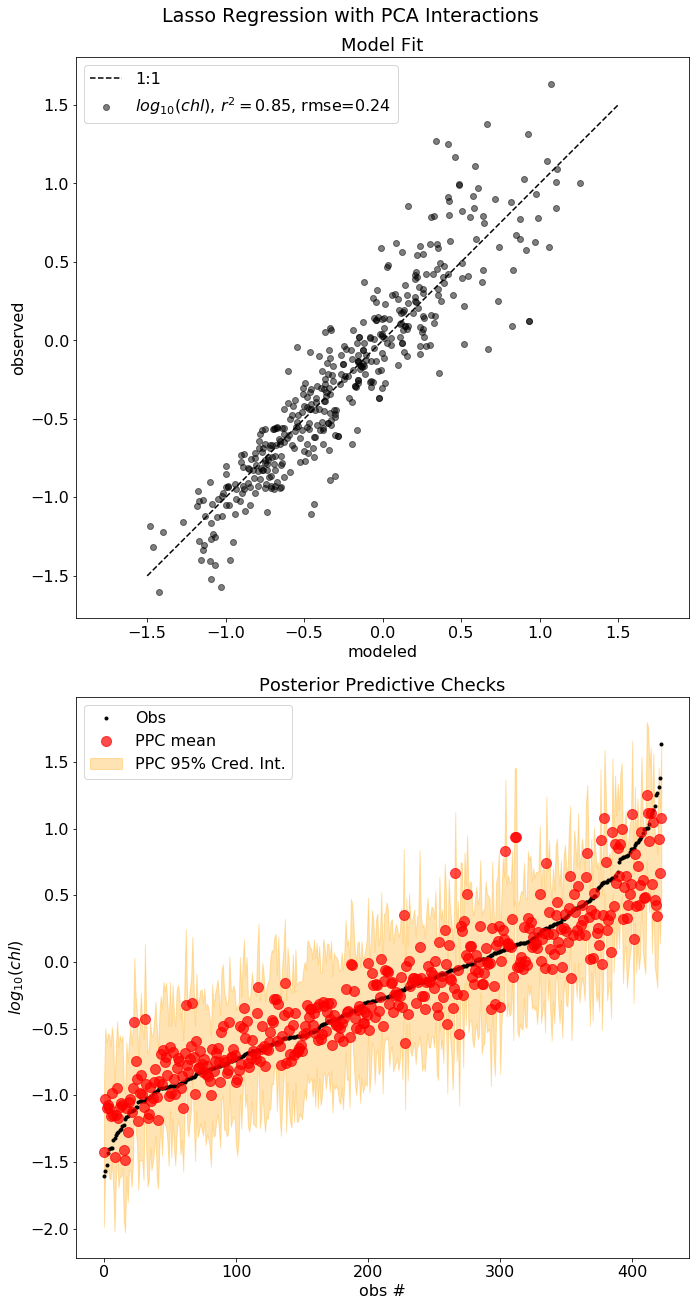

In [112]:
title = 'Lasso Regression with PCA Interactions'
ax1lps = Plot_Model_Fits(tpcap_lasso, mpcap_lasso, title=title)

In [113]:
dpcap_lasso = pm.summary(tpcap_lasso, varnames=vars_)
lbls = dpcapoly_s.loc[:, 'PC1_s':].columns.tolist()[:-1]
lbls_list = ['w[bias]']+['w [%s]' % lbl for lbl in lbls]
dpcap_lasso.index = ['sd_beta', 'sigma'] + lbls_list
dpcap_lasso[(((dpcap_lasso['hpd_2.5']<0)&(dpcap_lasso['hpd_97.5']<0))|
                    ((dpcap_lasso['hpd_2.5']>0) & (dpcap_lasso['hpd_97.5']>0))
                   )]

,mean,sd,mc_error,hpd_2.5,hpd_97.5
sd_beta,0.062036,0.012120,0.000266,0.040379,0.086590
sigma,0.248721,0.009519,0.000209,0.231051,0.268008
w[bias],-0.202243,0.013227,0.000270,-0.225014,-0.173147
w [PC1_s],-0.515533,0.012822,0.000285,-0.540729,-0.490147
w [PC2_s],-0.099238,0.013078,0.000279,-0.126291,-0.074902
w [PC3_s],0.123315,0.012901,0.000255,0.097526,0.147527
w [PC4_s],0.066434,0.013903,0.000318,0.039784,0.093338
w [PC1_s PC2_s],0.189451,0.012737,0.000275,0.163772,0.212348
w [PC1_s PC3_s],0.029092,0.009069,0.000209,0.010777,0.046284
w [PC1_s PC4_s],-0.052251,0.010009,0.000232,-0.071747,-0.032555
